# Test case LVV-T83: Verify implementation of Bad Pixel Map

Verify that the DMS can produce a map of detector pixels that suffer from pathologies, and that these pathologies are encoded in at least 32-bit values.

In [1]:
from lsst.daf.butler import Butler

import matplotlib.pyplot as plt
import numpy as np

Initialize the Butler pointing to a collection in the Data Preview 1 (DP1) repository.

In [2]:
repo = '/repo/dp1'
collection = "LSSTComCam/runs/DRP/DP1/v29_0_0/DM-50260"

butler = Butler(repo, collections=collection)

#### Retrieve and examine the `defects` dataset

The bad pixel mask has dataset type `defects` in the LSST Science Pipelines. Retrieve one of these and examine its properties.

In [3]:
# Query for all defects datasets in the collection:
defects_refs = butler.query_datasets('defects')

In [4]:
# Select the first from the list:
defects0 = butler.get('defects', dataId=defects_refs[0].dataId)

In [5]:
# Extract the data to a dict for examination:
defects_dict = defects0.toDict()

# Print the list of keys:
print(defects_dict.keys())

dict_keys(['metadata', 'x0', 'y0', 'width', 'height'])


Examine the metadata for this defect mask.

In [6]:
for md in defects_dict['metadata']:
    print(f"{md}: {defects_dict['metadata'][md]}")

OBSTYPE: defects
defects_SCHEMA: 
defects_VERSION: 2.0
INSTRUME: LSSTComCam
RAFTNAME: None
SLOTNAME: R22
DETECTOR: 0
DET_NAME: R22_S00
DET_SER: ITL-3800C-229
FILTER: None
CALIB_ID: instrument=LSSTComCam raftName=R22 detectorName=R22_S00 calibDate=2025-02-07T17:08:53.543546
SEQFILE: None
SEQNAME: None
SEQCKSUM: None
CALIBCLS: lsst.ip.isr.defects.Defects
ODP: 26.9
AP0_RC: 14
CALIBDATE: 2025-02-07T17:08:53.543546
CALIB_CREATION_DATE: 2025-02-07
CALIB_CREATION_TIME: 17:08:53.543546
LSST BUTLER ID: 1a4dc667-8319-43f5-931f-e7c1a326ef08
LSST BUTLER RUN: LSSTComCam/calib/DM-4852...250207a/20250208T010419Z
LSST BUTLER DATASETTYPE: defects
LSST BUTLER DATAID DETECTOR: 0
LSST BUTLER DATAID INSTRUMENT: LSSTComCam
LSST BUTLER QUANTUM: 0f5307d0-66b9-4078-9b2b-7730d34779f6
LSST BUTLER INPUT 0 ID: 4864dd77-ef17-49ba-a668-19ed6301f86e
LSST BUTLER INPUT 0 RUN: LSSTComCam/calib/DM-...07a/20250208T010419Z
LSST BUTLER INPUT 0 DATASETTYPE: cpDefectsFromFlatBootstrap
LSST BUTLER INPUT 1 ID: 5094970a-d6c4-4f2

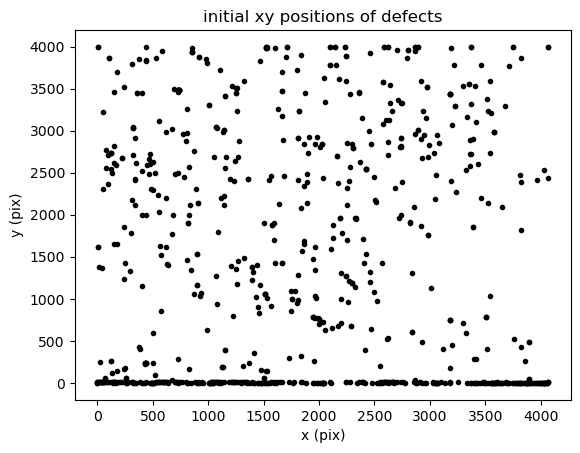

In [7]:
plt.plot(defects_dict['x0'], defects_dict['y0'], 'k.')
plt.xlabel('x (pix)')
plt.ylabel('y (pix)')
plt.title('initial xy positions of defects')
plt.show()

Extract the defects to a Table, and calculate the area marked as "bad."

The defects mask encodes defects with an initial x and y position, and a width and height spanned by each defect. Thus to find the total area affected, we can multiply the width*height for each defect, then sum them.

In [8]:
defects_tab = defects0.toTable()

In [9]:
defects_area = (defects_tab[0]['width']*defects_tab[0]['height'])
print('total defects area: ', np.sum(defects_area))

total defects area:  99903


#### Calculate the fraction of pixels that have been masked.

Extract the mask plane of a processed image, then mask the pixels from the `defects` dataset, and calculate the fraction of the total area that has been masked.

In [10]:
img_refs = butler.query_datasets('preliminary_visit_image', where="detector=4")

In [11]:
img = butler.get(img_refs[0])

In [12]:
# Clone the mask, then clear all mask planes:
msk0 = img.mask.clone()
msk0.clearAllMaskPlanes()

In [13]:
# Set the mask by applying the defects to the cleared mask array
defects0.maskPixels(msk0)

In [14]:
# Count the number of masked pixels
np.sum(msk0.array)

np.int64(99903)

In [15]:
# Count the total number of pixels
np.size(msk0.array)

16288000

In [16]:
# Calculate the ratio of masked/total pixels
np.sum(msk0.array)/np.size(msk0.array)

np.float64(0.006133533889980353)

We see that about 0.6% of the pixels are masked as "BAD".

We can also extract mask pixels with odd values -- because the "BAD" mask bit is 0, any (and only) pixels masked as "BAD" will have odd values in the mask. Count them:

In [17]:
badflag = (img.mask.array % 2 == True) & (img.mask.array > 0)
len(img.mask.array[badflag]) / len(img.mask.array.flatten())

0.012797949410609038

There are roughly 1.3% of the pixels masked as "BAD" in the retrieved image. This is larger than the number from the `defects` mask alone, but this is expected because additional pixels (e.g., near the edges of images) are masked during ISR.

## Results

We have confirmed that the `defects` mask is available and can be retrieved by users.

However, the `defects` are only encoded as a binary (True/False) "BAD" value, rather than the required 32-bit encoding. Thus, this test is a **Partial Pass** based on the fact that the bad pixel mask is available, but that it needs improvement to encode more detail.